# Setup

## Mounting Google Drive (optional)
Also checks for a connected GPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount drive

# Check to see if using a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU.')
  print('It is highly recommended you change your runtime type from CPU (standard) to GPU.')

Mounted at /content/drive


## Importing libraries

In [38]:
# Adversarial Robustness Toolbox (ART)
# Library for adversarial attacks
# Isn't included in Google Colab, have to download via pip
try:
  __import__('art')
except ImportError:
  !pip install Adversarial-Robustness-Toolbox
from art.attacks.evasion import ProjectedGradientDescent, FastGradientMethod, DeepFool, PixelAttack
from art.estimators.classification import KerasClassifier # Used to generate attacks for KerasClassifier models

# Tensorflow library for neural network models,
#   training, and preprocessing
import tensorflow
from tensorflow.keras import Input                          # Input layer of network
from tensorflow.keras.applications import VGG16             # VGG16 model architecture
from tensorflow.keras.callbacks import EarlyStopping        # Callback, can be used to stop training early provided some condition is met
from tensorflow.keras.layers import Dense, Flatten          # Dense layer = fully connected neural network layer, Flatten layer takes x-dimensional input (like an image) and flattens to a single dimension
from tensorflow.keras.models import Sequential, load_model  # Sequential model is assembled from a list of models/layers, load_model loads a tensorflow keras model
from tensorflow.keras.optimizers import Adam                # Optimizer for training
from tensorflow.keras.utils import to_categorical           # Converts list of discrete values into a list of onehot-encoded vectors

import pickle                     # Loading/saving data
import pandas as pd               # Loading CVs
import numpy as np                # Arrays, used for images
from tabulate import tabulate     # Printing tables
import matplotlib.pyplot as plt   # Plotting images and graphs
import random                     # Random shuffle and selecting random elements from a list

# ART requires that eager execution is disabled
tensorflow.compat.v1.disable_eager_execution()

## Setting paths/directories/variables

In [39]:
# =========== These paths are paths to files that are prerequisites. These files are not generated by this notebook.

DATA_PATH = 'drive/My Drive/Colab Notebooks/data.pickled'             # Output from data_loader.ipynb
NAME_LIST_PATH = 'drive/My Drive/Colab Notebooks/LFW/name_list.csv'   # List of names, included with LFW dataset


# =========== The rest of the paths are paths to files that are not prerequisites. They will be generated by this notebook if they do not exist.
# This will be done using try blocks and exceptions
# The notebook will try to load the data from the path, and if there is an exception it will generate it and save it to the path

VGGNET_PATH = 'drive/My Drive/Colab Notebooks/vggnet.h5'                        # Modified VGG16 model trained on the LFW dataset
FGSM_DETECTOR_PATH = 'drive/My Drive/Colab Notebooks/fgsm_detector.h5'          # Model trained to detect FGSM-attacked images
PGD_DETECTOR_PATH = 'drive/My Drive/Colab Notebooks/pgd_detector.h5'            # Model trained to detect PGD-attacked images
DEEPFOOL_DETECTOR_PATH = 'drive/My Drive/Colab Notebooks/deepfool_detector.h5'  # Model trained to detect Deepfool-attacked images

VGGNET_HIST_PATH = 'drive/My Drive/Colab Notebooks/vggnet_history.pickled'                      # Training history of the modified VGG16
FGSM_DETECTOR_HIST_PATH = 'drive/My Drive/Colab Notebooks/fgsm_detector_hist.pickled'           # Training history of the FGSM detector
PGD_DETECTOR_HIST_PATH = 'drive/My Drive/Colab Notebooks/pgd_detector_hist.pickled'             # Training history of the PGD detector
DEEPFOOL_DETECTOR_HIST_PATH = 'drive/My Drive/Colab Notebooks/deepfool_detector_hist.pickled'   # Training history of the Deepfool detector

ADV_ATTACK_INDICES_PATH = 'drive/My Drive/Colab Notebooks/adv_attack_indices.pickled'           # Random indices of images to attack, also used as indices for images to adversarially train with Fast Gradient Sign Method attack (FGSM)
PGD_TRAIN_INDICES_PATH = 'drive/My Drive/Colab Notebooks/pgd_train_indices.pickled'             # Random indices to adversarially train with Projected Gradient Descent (PGD) attack
DEEPFOOL_TRAIN_INDICES_PATH = 'drive/My Drive/Colab Notebooks/deepfool_train_indices.pickled'   # Random indices to adversarially train with Deepfool attack
# The indices are necessary to save in order to be able to find the corresponding labels from the original data

FGSM_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/fgsm_attack.pickled'           # FGSM attack against undefended VGG16 model
PGD_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/pgd_attack.pickled'             # PGD attack against undefended VGG16 model
DEEPFOOL_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/deepfool_attack.pickled'   # Deepfool attack against undefended VGG16 model
PIXEL_ATTACK_PATH = 'drive/My Drive/Colab Notebooks/pixel_attack.pickled'         # Pixel attack against undefended VGG16 model

FGSM_TRAIN_DATA_PATH = 'drive/My Drive/Colab Notebooks/fgsm_train_data.pickled'           # FGSM-attacked images for training FGSM detector
PGD_TRAIN_DATA_PATH = 'drive/My Drive/Colab Notebooks/pgd_train_data.pickled'             # PGD-attacked images for training PGD detector
DEEPFOOL_TRAIN_DATA_PATH = 'drive/My Drive/Colab Notebooks/deepfool_train_data.pickled'   # Deepfool-attacked images for training Deepfool detector

FGSM_DETECTOR_TEST_DATA_PATH = 'drive/My Drive/Colab Notebooks/fgsm_detector_test_data.pickled'   # FGSM-attacked images to test the FGSM detector with 
PGD_DETECTOR_TEST_DATA_PATH = 'drive/My Drive/Colab Notebooks/pgd_detector_test_data.pickled'     # PGD-attacked iamges to test the PGD detector with

IMG_SHAPE = (100, 100, 3) # Shape of the image (H x W x RGB)
SINGLE_IMG_BATCH_SHAPE = (1, 100, 100, 3) # Image shape as a batch of 1 image

# Hyperparameters
LR = 1e-4 # Learning rate
NUM_EPOCHS = 100 # Maximum number of epochs to train the models for. EarlyStop callback could stop the model from training all 100 epochs
BATCH_SIZE = 32 # Size of the batches used to train the model

EPSILON_FGSM = 3.2 / 255                        # Maximum noise value for the FGSM attacks
EPSILON_PGD = 3.0 / 255                         # Maximum noise value for the PGD attacks
EPSILON_DEEPFOOL = 1e-6                         # Maximum noise value for the Deepfool attacks
EPSILONS = [1, 3, 5, 10, 20]                    # Used to loop through and generate images with different amounts of noise
EPSILONS_SCALED = np.asarray(EPSILONS) / 255.0  # Scaled the epsilons to 0.0-1.0

## Loading data

In [4]:
# Try to load output from data_loader.ipynb
try:
  with open(DATA_PATH, 'rb') as infile:
    x_train, y_train, x_test, y_test, x_val, y_val = pickle.load(infile) # Unpacks tuple into different sets
except FileNotFoundError as error:
  print(error)
  print(f'Data could not be found at "{DATA_PATH}". Did you run the "data_loader.ipynb" notebook?')

CLASSES = pd.read_csv(NAME_LIST_PATH).values  # List of all names and their numbers, used for printing
CLASSES = [i[1] for i in CLASSES]             # Separate the names and their numbers and store only the names. The numbers are unnecessary because they are also the indices of the names in this case
NUM_CLASSES = len(CLASSES)                    # Get the number of classes. This will be the output dimension of the VGG16 classifier

## Double-checking data

In [5]:
print('Testing data shapes')
print(f'X: {x_test.shape}')
print(f'y: {y_test.shape}\n')

print('Training data shapes')
print(f'X: {x_train.shape}')
print(f'y: {y_train.shape}\n')

print('Validation data shapes')
print(f'X: {x_val.shape}')
print(f'y: {y_val.shape}\n')

Testing data shapes
X: (1049, 100, 100, 3)
y: (1049, 62)

Training data shapes
X: (3043, 100, 100, 3)
y: (3043, 62)

Validation data shapes
X: (1021, 100, 100, 3)
y: (1021, 62)



# Task 1

## Create and train model or load trained model

In [6]:
try: # Load the modified VGG16 classifier and its training history
  vggnet = load_model(VGGNET_PATH)
  with open(VGGNET_HIST_PATH, 'rb') as infile:
    vggnet_history = pickle.load(infile)
except:
  # Create a sequential model
  vggnet = Sequential([
    VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=IMG_SHAPE)), # VGG16 as the input, pretrained on ImageNet database, modified to take 100x100x3 images as input
    Flatten(), # Flatten layer, flattens multiple dimensions to a single dimension
    Dense(NUM_CLASSES, activation='softmax') # Output layer, fully-connected. Activation function is softmax and the number of neurons is the number of classes
  ])

  # Compile the model with optimizer Adam (with a provided learning rate),
  #   loss function categorical crossentropy,
  #   and keep track of the accuracy metric (not just loss)
  vggnet.compile(optimizer=Adam(learning_rate=LR), loss="categorical_crossentropy", metrics=['accuracy'])

  # Callback that monitors the validation loss and stops training when the loss stops decreasing
  # Patience of 10 epochs. If the validation loss increases (bad) then it will wait 10 epochs to see if it goes back down and then continue training. Otherwise, it will stop training.
  early_stop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=10)

  # Train the model and get the history (loss and accuracy over the epochs)
  vggnet_history = vggnet.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop_callback]).history

  vggnet.save(VGGNET_PATH) # Save the model
  with open(VGGNET_HIST_PATH, 'wb') as outfile: # Save the history as a pickled object
    pickle.dump(vggnet_history, outfile)

## Report

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


VGG16
Train set accuracy: 100.0%
Validation set accuracy: 94.32%
Test set accuracy: 94.76%


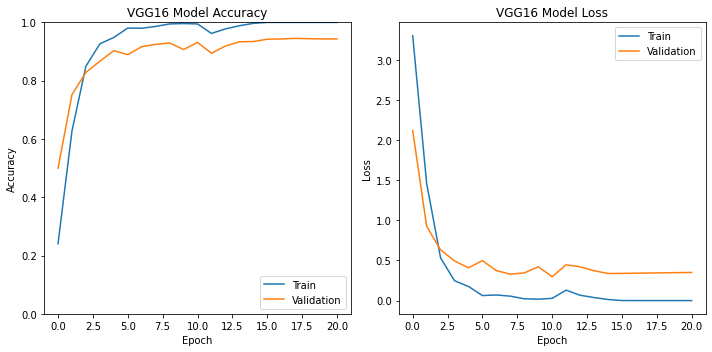

In [7]:
# Test the model on clean images
test_accuracy = vggnet.test_on_batch(x=x_test, y=y_test)[1]

# Print its accuracy
print('VGG16')
print('Train set accuracy: ' + str(round(vggnet_history['accuracy'][-1] * 100, 2)) + '%') # Print the last training accuracy in the history
print('Validation set accuracy: ' + str(round(vggnet_history['val_accuracy'][-1] * 100, 2)) + '%') # Print the last validation accuracy in the history
print('Test set accuracy: ' + str(round(test_accuracy * 100, 2)) + '%')


### Plot metrics
plt.figure(figsize=(10, 5))

# Subplot for accuracy graph
plt.subplot(1, 2, 1)

plt.plot(vggnet_history['accuracy']) # Plot the training accuracy over epoch
plt.plot(vggnet_history['val_accuracy']) # Plot the validation accuracy over epoch
plt.title('VGG16 Model Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right') # Add a legend
plt.ylim([0, 1.0]) # Set bounds to [0-100%]
# Add axis labels
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Loss
plt.subplot(1, 2, 2)

plt.plot(vggnet_history['loss']) # Plot the training loss over epoch
plt.plot(vggnet_history['val_loss']) # Plot the validation loss over epoch
plt.title('VGG16 Model Loss')
plt.legend(['Train', 'Validation'], loc='upper right') # Legend
# Axis labels
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()  # Tight layout, subplots are closer together
plt.show()          # Show plot

# Task 2

## Functions for generating/plotting adversarial images

In [47]:
# Function for generating adversarial images with PGD
# Optional target argument
# If no target is provided, then it does an untargeted attack
def get_adv_images_PGD(classifier, images, epsilon, target=None):
  if (target is None): # No target class was provided
    attacker = ProjectedGradientDescent(estimator=classifier, eps=epsilon, targeted=False) # Make an attacker
    x_attack = attacker.generate(x=images) # Generate an attack with the attacker
  else:
    attacker = ProjectedGradientDescent(estimator=classifier, eps=epsilon, targeted=True) # Make an attacker
    x_attack = attacker.generate(x=images, y=target) # Generate an attack with the attacker
  return x_attack # Return the attack

# Function for generating adversarial images with PGD
# Optional target argument
def get_adv_images_FGSM(classifier, images, epsilon, target=None):
  if (target is None): # Untargeted attack
    attacker = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)
    x_attack = attacker.generate(x=images)
  else: # Targeted attack
    attacker = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)
    x_attack = attacker.generate(x=images, y=target)
  return x_attack # Return the generated attack

# Function for generating adversarial images with DeepFool
# Optional labels argument, true labels of the provided x data
def get_adv_images_DeepFool(classifier, images, epsilon, labels=None):
  attacker = DeepFool(classifier=classifier, epsilon=epsilon) # Create attacker
  if (labels is None): # Generate attacks without provided labels
    x_attack = attacker.generate(x=images)
  else: # Generate attack with provided labels
    x_attack = attacker.generate(x=images, y=labels)
  return x_attack # Return attack

# Function for generating adversarial images with Pixel attack
# Optional labels argument, true labels of the provided x data
def get_adv_images_Pixel(classifier, images, labels):
  # attacker = DeepFool(classifier=classifier, epsilon=epsilon) # Create attacker
  attacker = PixelAttack(classifier=classifier, verbose=True, max_iter=10)
  x_attack = attacker.generate(x=images, y=labels)
  return x_attack # Return attack

# Function for plotting images with titles
def plot_images(images, titles, num_cols, figsize):
  # Calculate number of rows needed
  num_rows = len(images) / num_cols + 1
  # Plot a figure
  plt.figure(figsize=figsize)

  for i in range(len(images)):
    # Plot a sublot
    #           num rows, num cols, index
    plt.subplot(num_rows, num_cols, i + 1)
    # Add a title, show the image, diasble axes
    plt.title(titles[i])    
    plt.imshow(images[i].reshape(IMG_SHAPE))
    plt.axis('off')
  # Show the plot
  plt.show()

# Tests a model and plots the results
def test_model_and_plot(model, x, y, num_cols, figsize, title=None):
  if (title is not None):
    print(title)
  titles = [] # Title for each image to be printed
  for i in range(len(x)): # Loop through each input image
    prediction = model.predict(x=x[i].reshape(SINGLE_IMG_BATCH_SHAPE)) # Make a prediction
    prediction = np.argmax(prediction) # Get the index of the class with the highest probability (according to the model)
    prediction = CLASSES[prediction] # Get the name of the predicted class from the prediction
    true_label = CLASSES[np.argmax(y[i])] # Get the name of the true class

    titles.append(f'Label: {true_label}\nPrediction: {prediction}') # Append the predicted and true label as a string to the titles list
  
  plot_images(images=x, titles=titles, num_cols=num_cols, figsize=figsize) # Call the plot_images function

# Function that returns random integers in a range with no repeats
def randints_no_repeat(low:int, high:int, number:int):
  if (number > high - low):
    raise ValueError("Can't generate more non-repeating integers than are in the range.")
    return None

  ints = []
  for i in range(number):
    x = random.randint(low, high - 1) # Generate a random number
    while (x in ints): # Keep generating random numbers until one is generated that isn't in the list (probably not the most efficient way)
      x = random.randint(low, high - 1)
    ints.append(x) # Append it to the list
  return np.asarray(ints).astype(np.int) # Return the list

## Load or generate adversarial images

In [ ]:
classifier = KerasClassifier(model=vggnet, clip_values=(0.0, 1.0)) # Create an ART keras classifier with the undefended model

try: # Try to read the previously-generated attacks
  with open(ADV_ATTACK_INDICES_PATH, 'rb') as infile:
    adv_attack_indices = pickle.load(infile)
  with open(FGSM_ATTACK_PATH, 'rb') as infile:
    x_adv_fgsm = pickle.load(infile)
  with open(PGD_ATTACK_PATH, 'rb') as infile:
    x_adv_pgd = pickle.load(infile)
  with open(DEEPFOOL_ATTACK_PATH, 'rb') as infile:
    x_adv_deepfool = pickle.load(infile)
  with open(PIXEL_ATTACK_PATH, 'rb') as infile:
    x_adv_pixel = pickle.load(infile)
except FileNotFoundError: # If there are none, generate the attacks and then save them
  adv_attack_indices = randints_no_repeat(0, x_test.shape[0], 100) # Get 100 random indices

  # Attack the images at the 100 random indices with FGSM, PGD, Deepfool, and Pixel
  x_adv_fgsm = get_adv_images_FGSM(classifier, images=x_test[adv_attack_indices], epsilon=EPSILON_FGSM) 
  x_adv_pgd = get_adv_images_PGD(classifier, images=x_test[adv_attack_indices], epsilon=EPSILON_PGD)
  x_adv_deepfool = get_adv_images_DeepFool(classifier, images=x_test[adv_attack_indices], epsilon=EPSILON_DEEPFOOL)
  x_adv_pixel = get_adv_images_Pixel(classifier, images=x_test[adv_attack_indices], labels=y_test[adv_attack_indices])

  # Save the indices (used to match the attacks to the correct labels/classes)
  with open(ADV_ATTACK_INDICES_PATH, 'wb') as outfile:
    pickle.dump(adv_attack_indices, outfile)
  # Save the attacks - FGSM, PGD, and Deepfool - in different files
  with open(FGSM_ATTACK_PATH, 'wb') as outfile:
    pickle.dump(x_adv_fgsm, outfile)
  with open(PGD_ATTACK_PATH, 'wb') as outfile:
    pickle.dump(x_adv_pgd, outfile)
  with open(DEEPFOOL_ATTACK_PATH, 'wb') as outfile:
    pickle.dump(x_adv_deepfool, outfile)
  with open(PIXEL_ATTACK_PATH, 'wb') as outfile:
    pickle.dump(x_adv_pixel, outfile)

Pixel threshold: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/art/attacks/evasion/pixel_threshold.py:1219: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence,


## Report

In [10]:
y_adv_test = y_test[adv_attack_indices] # Get the correct labels to test the model with (alongside the attacked images)

clean_accuracy = str(round(vggnet.test_on_batch(x=x_test[adv_attack_indices], y=y_adv_test)[1] * 100, 2)) + '%' # Get the model's accuracy on clean/unperturbed images
fgsm_accuracy = str(round(vggnet.test_on_batch(x=x_adv_fgsm, y=y_adv_test)[1] * 100, 2)) + '%' # Get the model's accuracy on FGSM-attacked images
pgd_accuracy = str(round(vggnet.test_on_batch(x=x_adv_pgd, y=y_adv_test)[1] * 100, 2)) + '%' # Get the model's accuracy on PGD-attacked images
deepfool_accuracy = str(round(vggnet.test_on_batch(x=x_adv_deepfool, y=y_adv_test)[1] * 100, 2)) + '%' # Get the model's accuracy on Deepfool-attacked images
pixel_accuracy = str(round(vggnet.test_on_batch(x=x_adv_pixel, y=y_adv_test)[1] * 100, 2)) + '%' # Get the model's accuracy on Pixel-attacked images

# Create a table to print
table = [['Attack', 'Clean Image Accuracy', 'Adversarial Image Accuracy', 'Epsilon'], 
  ['VGG16 - FGSM', clean_accuracy, fgsm_accuracy, EPSILON_FGSM], 
  ['VGG16 - PGD', clean_accuracy, pgd_accuracy, EPSILON_PGD], 
  ['VGG16 - DeepFool', clean_accuracy, deepfool_accuracy, EPSILON_DEEPFOOL],
  ['VGG16 - Pixel', clean_accuracy, pixel_accuracy, 'NA']
]

print(tabulate(table))

----------------  --------------------  --------------------------  --------------------
Attack            Clean Image Accuracy  Adversarial Image Accuracy  Epsilon
VGG16 - FGSM      97.0%                 29.0%                       0.012549019607843138
VGG16 - PGD       97.0%                 12.0%                       0.011764705882352941
VGG16 - DeepFool  97.0%                 8.0%                        1e-06
----------------  --------------------  --------------------------  --------------------


FGSM


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


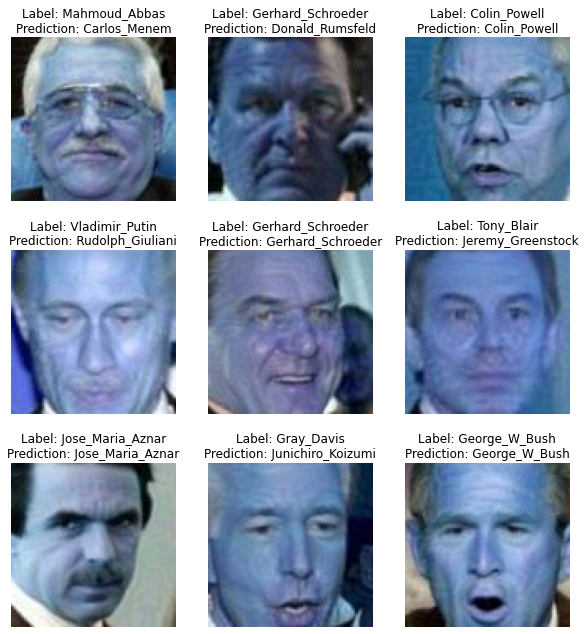

PGD


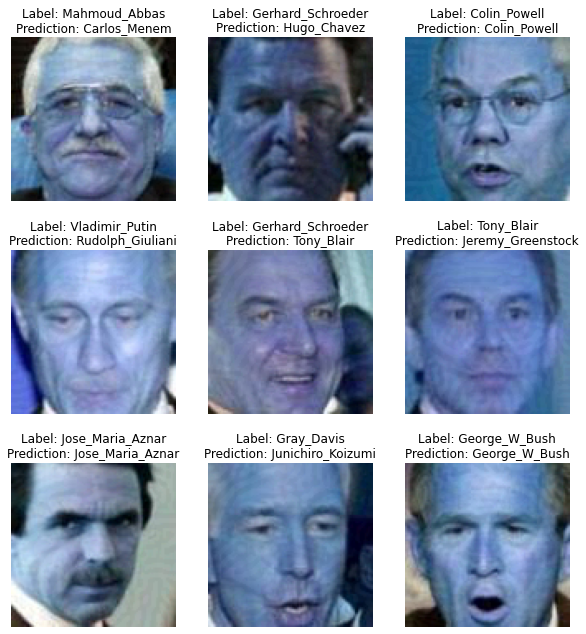

DeepFool


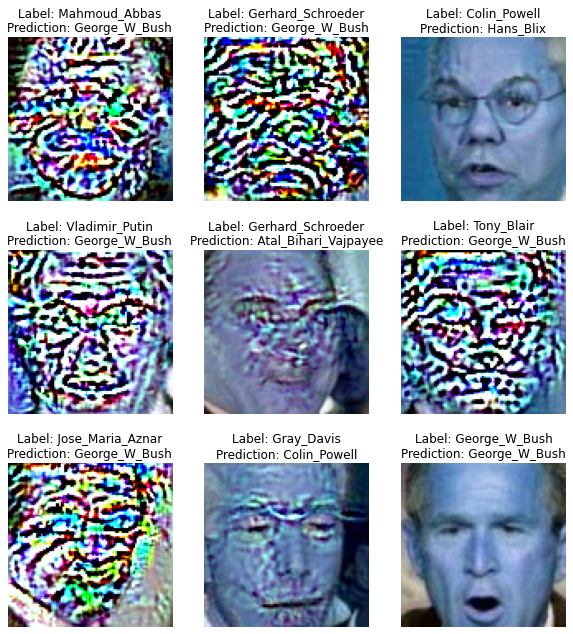

In [11]:
rand_test_indices = random.sample(adv_attack_indices, 9) # Get random indices for testing vggnet under attack
test_model_and_plot(model=vggnet, x=x_adv_fgsm[rand_test_indices], y=y_adv_test[rand_test_indices], num_cols=3, figsize=(10, 15), title='FGSM') # Test and plot with the FGSM-attacked images at the indices
test_model_and_plot(model=vggnet, x=x_adv_pgd[rand_test_indices], y=y_adv_test[rand_test_indices], num_cols=3, figsize=(10, 15), title='PGD') # Test and plot with the PGD-attacked images at the indices
test_model_and_plot(model=vggnet, x=x_adv_deepfool[rand_test_indices], y=y_adv_test[rand_test_indices], num_cols=3, figsize=(10, 15), title='DeepFool') # Test and plot with the Deepfool-attacked images at the indices
test_model_and_plot(model=vggnet, x=x_adv_pixel[rand_test_indices], y=y_adv_test[rand_test_indices], num_cols=3, figsize=(10, 15), title='Pixel') # Test and plot with the Pixel-attacked images at the indices

# Task 3

In [12]:
# Usually with keras models, you can use model.test_on_batch(...)
# However, if the batch is too large then you can exhaust all the GPU's memory
# This function splits a batch into batches of some size (increment), and then gets a weighted sum of the accuracies
# The last batch might be a full 1000 images, so it will be weighted accordingly
def test_on_batches(x, y, model, increment=1000):
  start = 0 # Starting index of the current batch
  acc = 0.0
  while True: # Loop forever until break
    end = start + increment # Ending index of the current batch
    if end > x.shape[0]: # If the ending index is out of range, then it will be a smaller batch
      batch_acc = model.test_on_batch(x=x[start:], y=y[start:])[1] # Test on all remaining images
      acc += batch_acc * ((x.shape[0] - start) / x.shape[0]) # Weigh the accuracy accordingly and add to the accuracy sum
      break # Break out of the while loop

    acc += (model.test_on_batch(x=x[start:end], y=y[start:end])[1] * (increment / x.shape[0])) # Test the full batch and add the weighted accuracy
    start += increment # Increment the starting index
  return acc # Return the accuracy

## FGSM

### Step 1

In [13]:
# The binary detectors will have two output classes
CLEAN_CLASS = 0 # The clean class
ADV_CLASS = 1 # The adversarially-attacked class

try: # Try to load the FGSM training data for the FGSM detector
  with open(FGSM_TRAIN_DATA_PATH, 'rb') as infile:
    x_train_fgsm, y_train_fgsm = pickle.load(infile)
except FileNotFoundError: # Cannot find it, then generate it and save it
  x_train_fgsm = get_adv_images_FGSM(classifier=classifier, images=x_train, epsilon=EPSILON_FGSM) # Generate the FGSM attack
  x_train_fgsm = np.concatenate((x_train, x_train_fgsm)) # Concatenate with the clean images to make the training set

  # Create the onehot labels
  y_train_fgsm = [CLEAN_CLASS] * x_train.shape[0]
  y_train_fgsm += [ADV_CLASS] * x_train.shape[0]
  y_train_fgsm = to_categorical(y_train_fgsm, num_classes=2)  

  # Save the dataset as a pickled tuple
  with open(FGSM_TRAIN_DATA_PATH, 'wb') as outfile:
    pickle.dump((x_train_fgsm, y_train_fgsm), outfile)

In [14]:
halfway_index = x_train_fgsm.shape[0] // 2 # Floor operator, get the middle index (round down if necessary)
accuracy = test_on_batches(x_train_fgsm[halfway_index:], y_train, vggnet) # Test the undefended model's accuracy
print(f'Undefended model accuracy on FGSM attack: {round(accuracy * 100, 2)}%')

Undefended model accuracy on FGSM attack: 39.8%


### Step 2

In [15]:
try: # Try to load the FGSM detector and its history
  fgsm_detector = load_model(FGSM_DETECTOR_PATH)

  with open(FGSM_DETECTOR_HIST_PATH, 'rb') as infile:
    fgsm_history = pickle.load(infile)

except: # Create the detector and save it
  fgsm_detector = Sequential([
    VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=IMG_SHAPE)), # Main part of the model is the VGG16 architecture
    Flatten(), # Flatten into single-dimension
    Dense(2, activation='softmax') # Binary classifcation, fuilly-connected layer with two neurons
  ])

  fgsm_detector.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy']) # Compile with the provided learning rate, loss function, and keep track of the accuracy as the model trains
  early_stop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=10) # Early stop callback, same as before
  fgsm_history = fgsm_detector.fit(x=x_train_fgsm, y=y_train_fgsm, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks=[early_stop_callback], validation_split=0.2, shuffle=True).history # Train the model and store the history

  fgsm_detector.save(FGSM_DETECTOR_PATH) # Save the model
  with open(FGSM_DETECTOR_HIST_PATH, 'wb') as outfile: # Save the model's training history
    pickle.dump(fgsm_history, outfile)

### Step 3

In [16]:
accuracy = test_on_batches(x_train_fgsm, y_train_fgsm, fgsm_detector) # Test the binary FGSM detector's accuracy
print(f'Binary FGSM detection accuracy: {round(accuracy * 100, 2)}%')

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Binary FGSM detection accuracy: 99.57%


In [17]:
# Generate onehot labels for testing
labels = [ADV_CLASS] * x_adv_fgsm.shape[0]
labels = to_categorical(labels, num_classes=2)

# Test the FGSM detector on FGSM-, PGD-, and Deepfool-attacked images
fgsm_accuracy = fgsm_detector.test_on_batch(x=x_adv_fgsm, y=labels)[1]
pgd_accuracy = fgsm_detector.test_on_batch(x=x_adv_pgd, y=labels)[1]
deepfool_accuracy = fgsm_detector.test_on_batch(x=x_adv_deepfool, y=labels)[1]

# Create and print a table
table = [
  ['FGSM Success Rate', 'PGD Success Rate', 'DeepFool Success Rate'],
  [f'{round(fgsm_accuracy * 100, 2)}%', f'{round(pgd_accuracy * 100, 2)}%', f'{round(deepfool_accuracy * 100, 2)}%']
]
print('FGSM Binary Detector')
print(tabulate(table))

FGSM Binary Detector
-----------------  ----------------  ---------------------
FGSM Success Rate  PGD Success Rate  DeepFool Success Rate
97.0%              100.0%            25.0%
-----------------  ----------------  ---------------------


### Step 4

In [18]:
try: # Try to load testing data for the FGSM detector
  with open(FGSM_DETECTOR_TEST_DATA_PATH, 'rb') as infile:
    fgsm_detector_test_data = pickle.load(infile)
except FileNotFoundError: # Generate testing data for the FGSM detector
  fgsm_detector_test_data = []  
  
  for epsilon in EPSILONS_SCALED: # Loop through the different epsilons and generate FGSM attacks
    fgsm_detector_test_data.append(get_adv_images_FGSM(classifier=classifier, images=x_test[adv_attack_indices], epsilon=epsilon))

  # Save the attacks
  with open(FGSM_DETECTOR_TEST_DATA_PATH, 'wb') as outfile:
    pickle.dump(fgsm_detector_test_data, outfile)

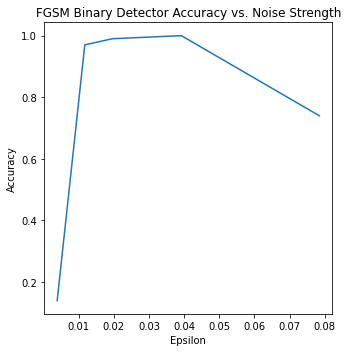

In [19]:
acc = [] # List to store accuracies
# Create binary onehot labels
labels = [ADV_CLASS] * y_adv_test.shape[0]
labels = to_categorical(labels, num_classes=2)

for group in fgsm_detector_test_data: # Loop through each epsilon group
  acc.append(fgsm_detector.test_on_batch(x=group, y=labels)[1]) # Test the model's accuracy and append it the list

### Plot metrics
plt.figure(figsize=(5, 5))
plt.plot(EPSILONS_SCALED, acc)
plt.title("FGSM Binary Detector Accuracy vs. Noise Strength")
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.tight_layout()
plt.show()

## PGD

### Step 1

In [20]:
try: # Try to load the training data for the PGD detector
  with open(PGD_TRAIN_INDICES_PATH, 'rb') as infile:
    pgd_indices = pickle.load(infile)
  with open(PGD_TRAIN_DATA_PATH, 'rb') as infile:
    x_train_pgd, y_train_pgd = pickle.load(infile)
except FileNotFoundError: # Create the training data for the PGD detector
  pgd_indices = randints_no_repeat(low=0, high=x_train.shape[0], number=1000) # Get 1000 random indices
  x_train_pgd = get_adv_images_PGD(classifier=classifier, images=x_train[pgd_indices], epsilon=EPSILON_PGD) # Create PGD attacks with the indices
  x_train_pgd = np.concatenate((x_train[pgd_indices], x_train_pgd)) # Concatenate with the clean images to create the training data

  # Create binary onehot labels
  y_train_pgd = [CLEAN_CLASS] * 1000
  y_train_pgd += [ADV_CLASS] * 1000
  y_train_pgd = to_categorical(y_train_pgd, num_classes=2)
  
  # Save the random indices
  with open(PGD_TRAIN_INDICES_PATH, 'wb') as outfile:
    pickle.dump(pgd_indices, outfile)

  # Save the training data
  with open(PGD_TRAIN_DATA_PATH, 'wb') as outfile:
    pickle.dump((x_train_pgd, y_train_pgd), outfile)

In [21]:
acc = vggnet.test_on_batch(x=x_train_pgd[1000:], y=y_train[pgd_indices])[1] # Test the undefended model on the PGD detector training data
print(f'Undefended model accuracy on PGD attack: {round(acc * 100, 2)}%')

Undefended model accuracy on PGD attack: 13.5%


### Step 2

In [22]:
try: # Try to load the PGD detector and its training history
  pgd_detector = load_model(PGD_DETECTOR_PATH)
  with open(PGD_DETECTOR_HIST_PATH, 'rb') as infile:
    pgd_history = pickle.load(infile)  
except: # Create the PGD detector and train it
  pgd_detector = Sequential([
    VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=IMG_SHAPE)), # Main part, the VGG16 model
    Flatten(), # Flatten into single dimension
    Dense(2, activation='softmax') # Binary classification layer
  ])

  pgd_detector.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy']) # Compile with optimizer and learning rate, loss function, and keep track of the model's accuracy
  early_stop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=10) # Early stop, same as before
  pgd_history = pgd_detector.fit(x=x_train_pgd, y=y_train_pgd, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks=[early_stop_callback], validation_split=0.2, shuffle=True).history # Train the model and store its history

  pgd_detector.save(PGD_DETECTOR_PATH) # Save the model
  with open(PGD_DETECTOR_HIST_PATH, 'wb') as outfile: # Save its history
    pickle.dump(pgd_history, outfile)

### Step 3

In [23]:
accuracy = test_on_batches(x_train_pgd, y_train_pgd, pgd_detector) # Test the PGD detector
print(f'Binary PGD detection accuracy: {round(accuracy * 100, 2)}%')

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Binary PGD detection accuracy: 98.9%


In [24]:
# Create binary onehot labels
labels = [ADV_CLASS] * x_adv_pgd.shape[0]
labels = to_categorical(labels, num_classes=2)

# Test the PGD detector on FGSM-, PGD-, and Deepfool-attacked images
fgsm_accuracy = pgd_detector.test_on_batch(x=x_adv_fgsm, y=labels)[1]
pgd_accuracy = pgd_detector.test_on_batch(x=x_adv_pgd, y=labels)[1]
deepfool_accuracy = pgd_detector.test_on_batch(x=x_adv_deepfool, y=labels)[1]

# Create an output table and print it
table = [
  ['FGSM Success Rate', 'PGD Success Rate', 'DeepFool Success Rate'],
  [f'{round(fgsm_accuracy * 100, 2)}%', f'{round(pgd_accuracy * 100, 2)}%', f'{round(deepfool_accuracy * 100, 2)}%']
]
print('PGD Binary Detector')
print(tabulate(table))

PGD Binary Detector
-----------------  ----------------  ---------------------
FGSM Success Rate  PGD Success Rate  DeepFool Success Rate
20.0%              99.0%             64.0%
-----------------  ----------------  ---------------------


### Step 4

In [25]:
try: # Load the PGD detector testing data
  with open(PGD_DETECTOR_TEST_DATA_PATH, 'rb') as infile:
    pgd_detector_test_data = pickle.load(infile)
except FileNotFoundError: # Create the PGD detector training data
  pgd_detector_test_data = []  
  
  for epsilon in EPSILONS_SCALED: # Loop through each epsilon and create the testing data
    pgd_detector_test_data.append(get_adv_images_PGD(classifier=classifier, images=x_test[adv_attack_indices], epsilon=epsilon))

  # Save the images
  with open(PGD_DETECTOR_TEST_DATA_PATH, 'wb') as outfile:
    pickle.dump(pgd_detector_test_data, outfile)

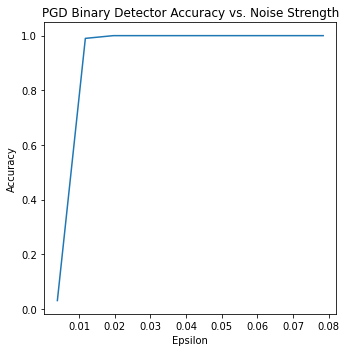

In [26]:
acc = [] # Stores the list of accuracies
# Create binary onehot labels
labels = [ADV_CLASS] * y_adv_test.shape[0]
labels = to_categorical(labels, num_classes=2)

for group in pgd_detector_test_data: # Loop through each attack
  acc.append(pgd_detector.test_on_batch(x=group, y=labels)[1]) # Test the model's accuracy and append it to the list

### Plot metrics
plt.figure(figsize=(5, 5))
plt.plot(EPSILONS_SCALED, acc)
plt.title('PGD Binary Detector Accuracy vs. Noise Strength')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.tight_layout()
plt.show()

## Deepfool

### Step 1

In [30]:
try: # Load the training data for the Deepfool detector
  with open(DEEPFOOL_TRAIN_INDICES_PATH, 'rb') as infile:
    deepfool_indices = pickle.load(infile)
  with open(DEEPFOOL_TRAIN_DATA_PATH, 'rb') as infile:
    x_train_deepfool, y_train_deepfool = pickle.load(infile)
except FileNotFoundError: # Create the training data for the Deepfool detector
  deepfool_indices = randints_no_repeat(low=0, high=x_train.shape[0], number=100) # Select only 100 random indices (Deepfool is very slow)
  x_train_deepfool = get_adv_images_DeepFool(classifier=classifier, images=x_train[deepfool_indices], epsilon=EPSILON_DEEPFOOL) # Generate the attacks on those indices
  x_train_deepfool = np.concatenate((x_train[deepfool_indices], x_train_deepfool)) # Concatenate with the clean images to create the dataset

  # Create binary onehot labels
  y_train_deepfool = [CLEAN_CLASS] * 100 + [ADV_CLASS] * 100
  y_train_deepfool = to_categorical(y_train_deepfool, num_classes=2)

  # Save the images and their labels
  with open(DEEPFOOL_TRAIN_DATA_PATH, 'wb') as outfile:
    pickle.dump((x_train_deepfool, y_train_deepfool), outfile)

  # Save the indices
  with open(DEEPFOOL_TRAIN_INDICES_PATH, 'wb') as outfile:
    pickle.dump(deepfool_indices, outfile)

In [31]:
acc = vggnet.test_on_batch(x=x_train_deepfool[100:], y=y_train[deepfool_indices])[1]
print(f'Undefended model accuracy on Deepfool attack: {round(acc * 100, 2)}%')

Undefended model accuracy on Deepfool attack: 22.0%


### Step 2

In [32]:
try: # Load the Deepfool detector model and its training history
  deepfool_detector = load_model(DEEPFOOL_DETECTOR_PATH)
  with open(DEEPFOOL_DETECTOR_HIST_PATH, 'rb') as infile:
    deepfool_history = pickle.load(infile)
except: # Create and save the Deepfool detector
  deepfool_detector = Sequential([
    VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=IMG_SHAPE)), # VGG16 architecture
    Flatten(), # Flatten into single dimension
    Dense(2, activation='softmax') # Binary classification layer
  ])

  deepfool_detector.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy']) # Compile with Adam with learning rate, categorical crossentropy loss function, and keep track of the model's accuracy
  early_stop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=10) # Early stop callback, same as before
  deepfool_history = deepfool_detector.fit(x=x_train_deepfool, y=y_train_deepfool, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks=[early_stop_callback], validation_split=0.2, shuffle=True).history # Train the model and store its training history

  deepfool_detector.save(DEEPFOOL_DETECTOR_PATH) # Save the model
  with open(DEEPFOOL_DETECTOR_HIST_PATH, 'wb') as outfile: # Save the model's training history
    pickle.dump(deepfool_history, outfile)

### Step 3

In [33]:
accuracy = test_on_batches(x_train_deepfool, y_train_deepfool, deepfool_detector) # Test the Deepfool detector's accuracy
print(f'Binary Deepfool detection accuracy: {round(accuracy * 100, 2)}%')

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Binary Deepfool detection accuracy: 82.0%


In [34]:
# Create binary onehot labels
labels = [ADV_CLASS] * x_adv_deepfool.shape[0]
labels = to_categorical(labels, num_classes=2)

# Test the model's accuracy on FGSM-, PGD-, and Deepfool-attacked images
fgsm_accuracy = deepfool_detector.test_on_batch(x=x_adv_fgsm, y=labels)[1]
pgd_accuracy = deepfool_detector.test_on_batch(x=x_adv_pgd, y=labels)[1]
deepfool_accuracy = deepfool_detector.test_on_batch(x=x_adv_deepfool, y=labels)[1]

# Create and print a table
table = [
  ['FGSM Success Rate', 'PGD Success Rate', 'DeepFool Success Rate'],
  [f'{round(fgsm_accuracy * 100, 2)}%', f'{round(pgd_accuracy * 100, 2)}%', f'{round(deepfool_accuracy * 100, 2)}%']
]
print('Deepfool Binary Detector')
print(tabulate(table))

Deepfool Binary Detector
-----------------  ----------------  ---------------------
FGSM Success Rate  PGD Success Rate  DeepFool Success Rate
0.0%               0.0%              69.0%
-----------------  ----------------  ---------------------


## Results

In [35]:
acc = [[0] * 7, [0] * 7, [0] * 7] # Create a table to store all the accuracies
# Create binary onehot labels
CLEAN_ONEHOT = to_categorical([CLEAN_CLASS], num_classes=2)
ADV_ONEHOT = to_categorical([ADV_CLASS], num_classes=2)

# Test the FGSM detector...
acc[0][0] = test_on_batches(x=x_train_fgsm[:len(x_train_fgsm) // 2], y=y_train_fgsm[:len(y_train_fgsm) // 2], model=fgsm_detector) # on clean images
acc[0][1] = test_on_batches(x=x_train_fgsm[len(x_train_fgsm) // 2:], y=y_train_fgsm[len(y_train_fgsm) // 2:], model=fgsm_detector) # on FGSM attack
acc[0][2] = test_on_batches(x=x_test[adv_attack_indices], y=np.asarray(list(CLEAN_ONEHOT) * len(adv_attack_indices)), model=fgsm_detector) # on clean images
acc[0][3] = test_on_batches(x=x_adv_fgsm, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=fgsm_detector) # on FGSM attack
acc[0][4] = test_on_batches(x=x_adv_pgd, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=fgsm_detector) # on PGD attack
acc[0][5] = test_on_batches(x=x_adv_deepfool, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=fgsm_detector) # on Deepfool attack
acc[0][6] = test_on_batches(x=x_adv_pixel, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=fgsm_detector) # on Pixel attack

# Test the PGD detector...
acc[1][0] = test_on_batches(x=x_train_fgsm[:len(x_train_fgsm) // 2], y=y_train_fgsm[:len(y_train_fgsm) // 2], model=pgd_detector) # on clean images
acc[1][1] = test_on_batches(x=x_train_fgsm[len(x_train_fgsm) // 2:], y=y_train_fgsm[len(y_train_fgsm) // 2:], model=pgd_detector) # on FGSM attack
acc[1][2] = test_on_batches(x=x_test[adv_attack_indices], y=np.asarray(list(CLEAN_ONEHOT) * len(adv_attack_indices)), model=pgd_detector) # on clean images
acc[1][3] = test_on_batches(x=x_adv_pgd, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=pgd_detector) # on PGD attack
acc[1][4] = test_on_batches(x=x_adv_fgsm, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=pgd_detector) # on FGSM attack
acc[1][5] = test_on_batches(x=x_adv_deepfool, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=pgd_detector) # on Deepfool attack
acc[1][6] = test_on_batches(x=x_adv_pixel, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=pgd_detector) # on Pixel attack

# Test the Deepfool detector...
acc[2][0] = test_on_batches(x=x_train_fgsm[:len(x_train_fgsm) // 2], y=y_train_fgsm[:len(y_train_fgsm) // 2], model=deepfool_detector) # on clean images
acc[2][1] = test_on_batches(x=x_train_fgsm[len(x_train_fgsm) // 2:], y=y_train_fgsm[len(y_train_fgsm) // 2:], model=deepfool_detector) # on FGSM attack
acc[2][2] = test_on_batches(x=x_test[adv_attack_indices], y=np.asarray(list(CLEAN_ONEHOT) * len(adv_attack_indices)), model=deepfool_detector) # on clean images
acc[2][3] = test_on_batches(x=x_adv_deepfool, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=deepfool_detector) # on Deepfool attack
acc[2][4] = test_on_batches(x=x_adv_fgsm, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=deepfool_detector) #on FGSM attack
acc[2][5] = test_on_batches(x=x_adv_pgd, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=deepfool_detector) # on PGD attack
acc[2][6] = test_on_batches(x=x_adv_pixel, y=np.asarray(list(ADV_ONEHOT) * len(adv_attack_indices)), model=deepfool_detector) # on Pixel attack

In [36]:
accTable = [[f'{round(j * 100, 2)}%' for j in i] for i in acc] # Format the accuracies into more-readable strings (0.97837253 => 97.84%)

# Specify the type of attack on columns 4 and 5
accTable[0][4] = f'PGD: {accTable[0][4]}'
accTable[1][4] = f'FGSM: {accTable[1][4]}'
accTable[2][4] = f'FGSM: {accTable[2][4]}'

accTable[0][5] = f'DF: {accTable[0][5]}'
accTable[1][5] = f'DF: {accTable[1][5]}'
accTable[2][5] = f'PGD: {accTable[2][5]}'

for i in range(3):
  accTable[i][6] = f'PX: {accTable[i][6]}'

# Insert row titles
accTable[0].insert(0, 'FGSM') 
accTable[1].insert(0, 'PGD') 
accTable[2].insert(0, 'Deepfool')

# Create the table and print it
table = [
  ['', 'Clean train images', 'Attacked train images', 'Clean subset of test images', 'Attacked subset of test images', 'Subset of test images attacked by:', 'Subset of test images attacked by:'],
  accTable[0],
  accTable[1],
  accTable[2]
]

print(tabulate(table))

--------  ------------------  ---------------------  ---------------------------  ------------------------------  ----------------------------------  ----------------------------------
          Clean train images  Attacked train images  Clean subset of test images  Attacked subset of test images  Subset of test images attacked by:  Subset of test images attacked by:
FGSM      99.9%               99.24%                 99.0%                        97.0%                           PGD: 100.0%                         DF: 25.0%
PGD       99.24%              35.23%                 100.0%                       99.0%                           FGSM: 20.0%                         DF: 64.0%
Deepfool  99.67%              0.56%                  100.0%                       69.0%                           FGSM: 0.0%                          PGD: 0.0%
--------  ------------------  ---------------------  ---------------------------  ------------------------------  ----------------------------------  